In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

import optuna



In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")

In [4]:
len(train_df)

11504798

In [5]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
test_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [7]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [8]:
train_df.Vehicle_Age.value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

In [9]:
train_df.Response.value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [10]:
train_df['Gender'].value_counts(dropna=False)

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

In [11]:
train_df['Gender'].replace({'Male' : 1, 'Female': 0}, inplace = True)
train_df['Vehicle_Damage'].replace({"Yes": 1, "No": 0}, inplace = True)
train_df['Vehicle_Age'].replace({"1-2 Year": 2, "< 1 Year" : 1, "> 2 Years" : 3}, inplace = True)

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

In [12]:
test_df['Gender'].replace({'Male' : 1, 'Female': 0}, inplace = True)
test_df['Vehicle_Damage'].replace({"Yes": 1, "No": 0}, inplace = True)
test_df['Vehicle_Age'].replace({"1-2 Year": 2, "< 1 Year" : 1, "> 2 Years" : 3}, inplace = True)

In [13]:
def add_feat(df):
    df['Age_Vehicle_Age'] = df['Age'] * df['Vehicle_Age']
    df['Age_Annual_Premium'] = df['Age'] * df['Annual_Premium']
    df['Vehicle_Damage_Annual_Premium'] = df['Vehicle_Damage'] * df['Annual_Premium']
    return df

In [14]:
add_feat(train_df)
add_feat(test_df)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_Vehicle_Age,Age_Annual_Premium,Vehicle_Damage_Annual_Premium
0,11504798,0,20,1,47.0,0,1,0,2630.0,160.0,228,20,52600.0,0.0
1,11504799,1,47,1,28.0,0,2,1,37483.0,124.0,123,94,1761701.0,37483.0
2,11504800,1,47,1,43.0,0,2,1,2630.0,26.0,271,94,123610.0,2630.0
3,11504801,0,22,1,47.0,1,1,0,24502.0,152.0,115,22,539044.0,0.0
4,11504802,1,51,1,19.0,0,2,0,34115.0,124.0,148,102,1739865.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7669861,19174659,1,57,1,28.0,0,2,1,51661.0,124.0,109,114,2944677.0,51661.0
7669862,19174660,1,28,1,50.0,1,1,0,25651.0,152.0,184,28,718228.0,0.0
7669863,19174661,1,47,1,33.0,1,2,0,2630.0,138.0,63,94,123610.0,0.0
7669864,19174662,1,30,1,28.0,0,1,1,38866.0,124.0,119,30,1165980.0,38866.0


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 15 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   Gender                         int64  
 2   Age                            int64  
 3   Driving_License                int64  
 4   Region_Code                    float64
 5   Previously_Insured             int64  
 6   Vehicle_Age                    int64  
 7   Vehicle_Damage                 int64  
 8   Annual_Premium                 float64
 9   Policy_Sales_Channel           float64
 10  Vintage                        int64  
 11  Response                       int64  
 12  Age_Vehicle_Age                int64  
 13  Age_Annual_Premium             float64
 14  Vehicle_Damage_Annual_Premium  float64
dtypes: float64(5), int64(10)
memory usage: 1.3 GB


In [16]:
train_df.set_index('id', inplace = True)

<Axes: >

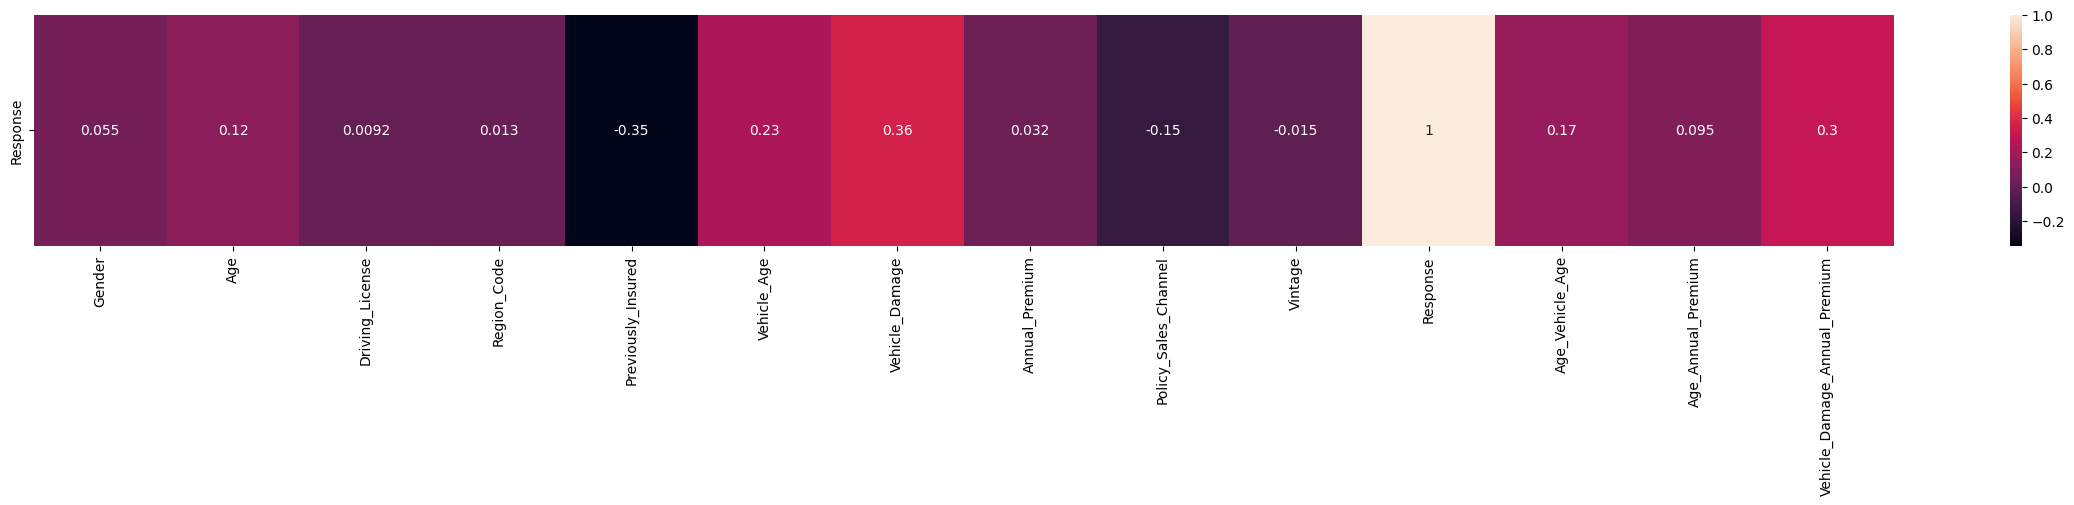

In [17]:
plt.figure(figsize=(30,3))
sns.heatmap(train_df.corr()[-4::4],annot=True)

In [18]:
def normalize_column(df, column_name):
    column = df[column_name]
    min_value = column.min()
    max_value = column.max()
    normalized_column = (column - min_value) / (max_value - min_value)
    return normalized_column

In [19]:
cols = ['Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Age_Vehicle_Age',
 'Age_Annual_Premium',
 'Vehicle_Damage_Annual_Premium']

In [20]:
for i in cols:
    train_df[i] = normalize_column(train_df ,i)
    test_df[i] = normalize_column(test_df ,i)

In [21]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(silent=True)
}

In [22]:
X = train_df.drop(['Response'], axis = 1)
y = train_df['Response']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [30]:
# # Create dataset for LightGBM
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# # Updated parameter setup
# params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'boosting_type': 'gbdt',
#     'num_leaves': 64,
#     'learning_rate': 0.075,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'lambda_l1': 0.1,
#     'lambda_l2': 0.1,
#     'max_depth': 10
# }

# # Train the model with updated parameters
# bst = lgb.train(
#     params,
#     train_data,
#     num_boost_round=1308,             # Increased boost rounds
#     valid_sets=[test_data],
#     callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(50)]
# )

# # Predict
# y_pred_prob = bst.predict(X_test, num_iteration=bst.best_iteration)


In [ ]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }
    
    # Use the eval_set parameter to apply early stopping
    evals = [(X_test, y_test)]
    bst = lgb.train(
        param,
        train_data,
        num_boost_round=1308,             # Increased boost rounds
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(50)])    
    # Predict probabilities and compute ROC AUC score
    y_prob = bst.predict(X_test)  # Probability estimates for the positive class
    auc = roc_auc_score(y_test, y_prob)
    
    return auc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-07-30 07:10:27,473] A new study created in memory with name: no-name-d9bee514-22ad-4f51-89b5-cf1622fe44ee
/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py:196: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  value_or_values = func(trial)


Training until validation scores don't improve for 20 rounds
[50]	valid_0's auc: 0.864921
[100]	valid_0's auc: 0.870547
[150]	valid_0's auc: 0.873421
[200]	valid_0's auc: 0.874984
[350]	valid_0's auc: 0.877667
[400]	valid_0's auc: 0.878088
Did not meet early stopping. Best iteration is:
[444]	valid_0's auc: 0.87849


[I 2024-07-30 07:18:35,810] Trial 0 finished with value: 0.8784903257229658 and parameters: {'n_estimators': 444, 'learning_rate': 0.13963282085859108, 'num_leaves': 114, 'max_depth': 4, 'lambda_l1': 6.323976382449948e-06, 'lambda_l2': 2.7102464243028575e-07, 'feature_fraction': 0.8703904686393454, 'bagging_fraction': 0.9434652812157256, 'bagging_freq': 4}. Best is trial 0 with value: 0.8784903257229658.
/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py:196: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  value_or_values = func(trial)


Training until validation scores don't improve for 20 rounds


In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

In [ ]:
test_df.set_index('id', inplace = True)

In [ ]:
pred = bst.predict(test_df)



In [ ]:
test_df.reset_index(inplace = True)

In [ ]:
sub = pd.DataFrame(test_df['id'])

In [ ]:
sub['Response'] = pred

In [ ]:
sub.to_csv("submission.csv",index = False)